## vanilla-DNN

Author: Justin Tan

Vanilla neural network. Do anything from MNIST to signal classification.

Update 20/03: Added batch normalization, TensorBoard visualization

Update 19/06: Added cosine annealing

To-do: Update to TF 1.2, fused batch norm

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time, os
import json

class config(object):
    # Set network parameters
    mode = 'kst'
    channel = 'rho0'
    n_features = 100
    keep_prob = 0.8
    num_epochs = 32
    batch_size = 256
    steps_per_epoch = 0
    n_layers = 7
    learning_rate = 2e-4
    min_learning_rate = 1e-6
    T_i = 32 # Warm restart every T_i epochs
    lr_epoch_decay = 0.98
    n_classes = 2
    hidden_layer_nodes = [1024, 1024, 1024, 512, 512, 512, 256]

class directories(object):
    data = 'data'
    tensorboard = 'tensorboard'
    checkpoints = 'checkpoints'
    
architecture = '{} - {} | Layers: {} | Dropout: {} | Base LR: {} | Epochs: {}'.format(
    config.channel, config.mode, config.n_layers, config.keep_prob, config.learning_rate, config.num_epochs)

class reader():
    # Iterates over data and returns batches
    def __init__(self, df):
        
        self.df = df
        self.batch_size = config.batch_size
        self.steps_per_epoch = len(df) // config.batch_size
        self.epochs = 0
        self.proceed = True
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.df_X = self.df.drop('labels', axis = 1)
        self.df_y = self.df['labels']
        self.pointer = 0


    def next_batch(self, batch_size):
        if self.pointer + 1 >= self.steps_per_epoch:
            inputs = self.df_X.iloc[self.pointer*batch_size:]
            targets = self.df_y.iloc[self.pointer*batch_size:]
            self.epochs += 1
            self.shuffle()
            self.proceed = False
            
        inputs = self.df_X.iloc[self.pointer*batch_size:(self.pointer+1)*batch_size]
        targets = self.df_y.iloc[self.pointer*batch_size:(self.pointer+1)*batch_size]
        self.pointer += 1
                
        return inputs, targets

### Functions for graph construction

In [6]:
def load_data(file_name, test_size = 0.05):
    from sklearn.model_selection import train_test_split
    df = pd.read_hdf(file_name, 'df')
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.drop('labels', axis = 1),
                                                                    df['labels'], test_size = test_size, random_state=42)
    return df_X_train, df_X_test, df_y_train, df_y_test

def save_summary(config, delta_t, train_acc, test_acc, test_auc):
    summary = {
        'Channel': config.channel,
        'Mode': config.mode,
        'Timestamp': time.strftime('%c'),
        'Hidden units': config.hidden_units,
        'Layers': config.n_layers,
        'Batch_size': config.batch_size,
        'Dropout': config.keep_prob,
        'Epochs': config.num_epochs,
        'Time': delta_t,
        'Final train acc': train_acc,
        'Final test acc': test_acc,
        'Final test AUC': test_auc
    }
    # Writing JSON data
    if os.path.isfile('vdnn_summary.json'):
        with open('vdnn_summary.json.', 'r+') as f:
            new = json.load(f)
        new.append(summary)
        with open('vdnn_summary.json', 'w') as f:
            json.dump(new, f, indent = 4)
    else:
        with open('vdnn_summary.json', 'w') as f:
             json.dump([summary], f, indent = 4)

def layer_weights(shape):
    # Return weight tensor of given shape using Xavier initialization
    W = tf.get_variable("weights", shape = shape, initializer=tf.contrib.layers.xavier_initializer())
    return W

def layer_biases(shape):
    # Return bias tensor of given shape with small initialized constant value
    b = tf.get_variable("biases", shape = shape, initializer = tf.constant_initializer(0.001))
    return b

def hidden_layer_ops(x, shape, name, keep_prob, activation=tf.nn.relu):
    # Add operations to graph to construct hidden layers
    with tf.variable_scope(name) as scope:
        # scope.reuse_variables() # otherwise tf.get_variable() checks that already existing vars are not shared by accident
        weights = layer_weights(shape = shape)
        biases = layer_biases(shape = [shape[1]])
        
        # Apply non-linearity. Default is ReLU
        actv = activation(tf.matmul(x, weights) + biases)
        layer_output = tf.nn.dropout(actv, keep_prob)
        
    return layer_output

def readout_ops(x, shape, name):
    # Don't apply non-linearity, dropout on output layer
    with tf.variable_scope(name) as scope:
        weights = layer_weights(shape = shape)
        biases = layer_biases(shape = [shape[1]])
        layer_output = tf.matmul(x, weights) + biases
        
    return layer_output

def BN_layer_ops(x, shape, name, keep_prob, phase, activation=tf.nn.relu):
    # High-level implementation of BN
    with tf.variable_scope(name) as scope:
         # scope.reuse_variables() # otherwise tf.get_variable() checks that already existing vars are not shared by accident
        weights = layer_weights(shape = shape)
        biases = layer_biases(shape = [shape[1]])
        z_BN = tf.matmul(x, weights) + biases
        
        # Place BN transform before non-linearity - update to TF 1.2!
        theta_BN = tf.contrib.layers.batch_norm(z_BN, center=True, scale=True,is_training=phase, 
                                                decay=0.99, zero_debias_moving_mean=True, scope='bn', fused = True)
        BN_actv = activation(theta_BN)
        BN_layer_output = tf.nn.dropout(BN_actv, keep_prob)

    return BN_layer_output

def build_network(x, n_layers, hidden_layer_nodes, training_phase):
    assert n_layers == len(hidden_layer_nodes), 'Specified layer nodes and number of layers do not correspond.'
    layers = [x]
    with tf.variable_scope('BN_layers') as scope:
        hidden_1 = BN_layer_ops(x, shape = [config.n_features, hidden_layer_nodes[0]], name = 'BNhidden0',
                                keep_prob = config.keep_prob, phase = training_phase)
        layers.append(hidden_1)
        for n in range(0,n_layers-1):
            hidden_n = BN_layer_ops(layers[-1], shape = [hidden_layer_nodes[n], hidden_layer_nodes[n+1]], name = 'BNhidden{}'.format(n+1),
                                   keep_prob = config.keep_prob, phase = training_phase)
            layers.append(hidden_n)

        readout = readout_ops(layers[-1], shape = [hidden_layer_nodes[-1], config.n_classes], name = 'readout')
        layers.append(readout)
        
        return layers

def plot_ROC_curve(network_output, y_true, meta = ''):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import roc_curve, auc

    y_score = network_output[:,1]
    
    # Compute ROC curve, integrate
    fpr, tpr, thresholds = roc_curve(y_true, y_score)    
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.axes([.1,.1,.8,.7])
    plt.figtext(.5,.9, r'$\mathrm{Receiver \;Operating \;Characteristic}$', fontsize=15, ha='center')
    plt.figtext(.5,.85, meta, fontsize=10,ha='center')
    plt.plot(fpr, tpr, color='darkorange',
                     lw=2, label='ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1.0, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'$\mathrm{False \;Positive \;Rate}$')
    plt.ylabel(r'$\mathrm{True \;Positive \;Rate}$')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join('graphs', '{}_{}_ROC.pdf'.format(config.channel, config.mode)), format='pdf', dpi=1000)
    plt.show()
    plt.gcf().clear()

In [7]:
test_file = '/data/dnn/norm_std_dnn_B02rho0gamma_kst.h5'

df_X_train, df_X_test, df_y_train, df_y_test = load_data(test_file)
df_y_train = df_y_train.astype(np.int8)
df_y_test = df_y_test.astype(np.int8)
df_train = pd.concat([df_X_train, df_y_train], axis = 1)
df_test = pd.concat([df_X_test, df_y_test], axis = 1)
config.n_features = df_train.shape[1]-1
config.steps_per_epoch = df_train.shape[0] // config.batch_size

readerTrain = reader(df_train)
readerTest = reader(df_test)

In [8]:
class vanillaDNN():
    # Builds the computational graph
    def __init__(self, config, training = True):
        
        self.config = config
        self.scope = 'vanilla'
        
        self.x = tf.placeholder(tf.float32, shape = [None, self.config.n_features])
        self.y_true = tf.placeholder(tf.int32, shape = None)
        self.keep_prob = tf.placeholder(tf.float32)
        self.training_phase = tf.placeholder(tf.bool)
        #self.eta = tf.placeholder(tf.float32)
        
        self.layers = build_network(self.x, self.config.n_layers, self.config.hidden_layer_nodes, self.training_phase)
        readout = self.layers[-1]
        self.prediction = tf.nn.softmax(readout)
        self.classification = tf.argmax(readout,1)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = readout, labels = self.y_true))
        tf.summary.scalar('cross_entropy', self.cross_entropy)
        
        # Anneal learning rate
        self.global_step = tf.Variable(0, trainable=False)
        self.beta = tf.train.exponential_decay(config.learning_rate, self.global_step,
                                                       decay_steps = config.steps_per_epoch, decay_rate = config.lr_epoch_decay, staircase=True)
        
        with tf.control_dependencies(update_ops):
            # Ensures that we execute the update_ops before performing the train_step
            self.train_op = tf.train.AdamOptimizer(self.beta).minimize(self.cross_entropy, name = 'optimizer',
                                                                                  global_step = self.global_step)  

        # Evaluation metrics
        correct_prediction = tf.equal(tf.cast(tf.argmax(readout, 1), tf.int32), self.y_true)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', self.accuracy)
        
        _, self.auc_op = tf.metrics.auc(predictions = tf.argmax(readout,1), labels = self.y_true, num_thresholds = 256)
        
        self.merge_op = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'train_{}'.format(time.strftime('%d-%m_%I:%M'))), graph = tf.get_default_graph())
        self.test_writer = tf.summary.FileWriter(
            os.path.join(directories.tensorboard, 'test_{}'.format(time.strftime('%d-%m_%I:%M'))))
        
    def predict(self, ckpt, metaGraph = None):
        saver = tf.train.Saver()
        
        with tf.Session() as sess:
            # Initialize variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            sess.run(tf.local_variables_initializer())

            start_time = time.time()
            
            assert (ckpt.model_checkpoint_path or metaGraph), 'Missing checkpoint file!'
            
            if metaGraph:
                saver = tf.train.import_meta_graph(metaGraph)
                saver.restore(sess, os.path.splitext(metaGraph)[0])
                print('{} restored.'.format(metaGraph))
            else:    
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('{} restored.'.format(ckpt.model_checkpoint_path))

            # Make predictions using the trained model
            feed_dict_test = {self.x: df_X_test.values, self.y_true: df_y_test.values, self.keep_prob: 1.0, self.training_phase: False}
            network_output_test, class_test, final_v_acc, final_v_auc = sess.run(
                [self.prediction, self.classification, self.accuracy, self.auc_op], feed_dict = feed_dict_test)

            print("Validation accuracy: {:g}\nValidation AUC: {:g}".format(final_v_acc, final_v_auc))
            
            plot_ROC_curve(network_output = network_output_test, y_true = df_y_test.values, meta = architecture)
            delta_t = time.time() - start_time
            print("Inference complete. Duration: %g s" %(delta_t))
            
            return network_output_test

In [9]:
def train(config, restore = False):
    # Executes training operations
    
    vDNN = vanillaDNN(config, training = True)
    start_time = time.time()
    v_acc_best = 0.
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
    
    with tf.Session() as sess:
        # Initialize variables
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        if restore and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('{} restored.'.format(ckpt.model_checkpoint_path))
            
        for epoch in range(config.num_epochs):
            
            readerTrain.proceed = True
            step = 0
            # Save every 10 epochs    
            if epoch % 10 == 0:
                save_path = saver.save(sess,
                                       os.path.join(directories.checkpoints,
                                                    'vDNN_{}_{}_epoch{}.ckpt'.format(config.mode, config.channel, epoch)),
                                       global_step = epoch)
                print('Graph saved to file: {}'.format(save_path))
                
            print('(*) Entering Epoch {} ({:.3f} s)'.format(epoch, time.time() - start_time))
#             T_c = epoch % config.T_i
#             eta_min, eta_max = sess.run([vDNN.eta_min, vDNN.eta_max])
#             eta = eta_min + 1/2*(eta_max - eta_min)*(1+np.cos(np.pi*(T_c/config.T_i)))
#             print('Learning rate: {}'.format(eta))
            
            while(readerTrain.proceed):
                # Iterate through entire corpus
                x_train, y_train = readerTrain.next_batch(config.batch_size)
                feed_dict_train = {vDNN.x: x_train.values, vDNN.y_true: y_train.values, 
                                   vDNN.keep_prob: config.keep_prob, vDNN.training_phase: True}#, vDNN.eta: eta}
                t_op = sess.run(vDNN.train_op, feed_dict = feed_dict_train)
                step += 1

                if step % (config.steps_per_epoch // 5) == 0:            
                    # Evaluate model
                    improved = ''
                    sess.run(tf.local_variables_initializer())
                    x_test, y_test = readerTest.next_batch(config.batch_size)
                    feed_dict_test = {vDNN.x: x_test.values, vDNN.y_true: y_test.values, vDNN.keep_prob: 1.0,
                                      vDNN.training_phase: False}#, vDNN.eta: eta}

                    t_acc, t_loss, t_summary = sess.run([vDNN.accuracy, vDNN.cross_entropy, vDNN.merge_op],
                                                        feed_dict = feed_dict_train)
                    v_acc, v_loss, v_auc, v_summary, = sess.run([vDNN.accuracy, vDNN.cross_entropy, vDNN.auc_op, vDNN.merge_op],
                                                        feed_dict = feed_dict_test)

                    vDNN.train_writer.add_summary(t_summary, step)
                    vDNN.test_writer.add_summary(v_summary, step)
                    
                    if epoch > 5 and v_acc > v_acc_best:
                        v_acc_best = v_acc
                        improved = '[*]'
                        save_path = saver.save(sess, 
                                               os.path.join(directories.checkpoints,
                                                            'vDNN_{}_{}_best.ckpt'.format(config.mode, config.channel)),
                                               global_step = epoch)
                    
                    print('Epoch {}, Step {} | Training Acc: {:.3f} | Test Acc: {:.3f} | Test Loss: {:.3f} | Test AUC {:.3f} ({:.2f} s) {}'
                          .format(epoch, step, t_acc, v_acc, v_loss, v_auc, time.time() - start_time, improved))

        save_path = saver.save(sess, os.path.join(directories.checkpoints, 'vDNN_{}_{}_end.ckpt'.format(config.mode, config.channel)),
                               global_step = epoch)
        print('Model saved to file: {}'.format(save_path))

        feed_dict_train = {vDNN.x: df_X_train.values, vDNN.y_true: df_y_train.values, vDNN.keep_prob: 1.0, vDNN.training_phase: False}
        feed_dict_test = {vDNN.x: df_X_test.values, vDNN.y_true: df_y_test.values, vDNN.keep_prob: 1.0, vDNN.training_phase: False}
        final_t_acc = vDNN.accuracy.eval(feed_dict = feed_dict_train)
        final_v_acc, final_v_AUC = sess.run([vDNN.accuracy, vDNN.auc_op], feed_dict = feed_dict_test)

        delta_t = time.time() - start_time
            
    print("Training Complete. Time elapsed: {:.3f} s".format(delta_t))
    print("Train accuracy: {:g}\nValidation accuracy: {:g}\nValidation AUC: {:g}".format(final_t_acc, final_v_acc, final_v_AUC))

    print('Architecture: {}'.format(architecture))
    save_summary(config, delta_t, final_t_acc, final_v_acc, final_v_AUC)

In [ ]:
train(config)#, restore = True)

Graph saved to file: checkpoints/vDNN_kst_rho0_epoch0.ckpt-0
(*) Entering Epoch 0 (1.549 s)
Epoch 0, Step 380 | Training Acc: 0.816 | Test Acc: 0.809 | Test Loss: 0.443 | Test AUC 0.803 (81.67 s) 
Epoch 0, Step 760 | Training Acc: 0.793 | Test Acc: 0.859 | Test Loss: 0.327 | Test AUC 0.849 (160.66 s) 
Epoch 0, Step 1140 | Training Acc: 0.828 | Test Acc: 0.812 | Test Loss: 0.430 | Test AUC 0.792 (239.44 s) 
Epoch 0, Step 1520 | Training Acc: 0.828 | Test Acc: 0.855 | Test Loss: 0.363 | Test AUC 0.834 (318.50 s) 
Epoch 0, Step 1900 | Training Acc: 0.852 | Test Acc: 0.863 | Test Loss: 0.315 | Test AUC 0.853 (400.50 s) 
(*) Entering Epoch 1 (400.502 s)
Epoch 1, Step 380 | Training Acc: 0.844 | Test Acc: 0.832 | Test Loss: 0.369 | Test AUC 0.819 (478.26 s) 
Epoch 1, Step 760 | Training Acc: 0.879 | Test Acc: 0.875 | Test Loss: 0.309 | Test AUC 0.867 (556.78 s) 
Epoch 1, Step 1140 | Training Acc: 0.867 | Test Acc: 0.844 | Test Loss: 0.394 | Test AUC 0.826 (634.95 s) 
Epoch 1, Step 1520 | Tra

Epoch 17, Step 760 | Training Acc: 0.910 | Test Acc: 0.852 | Test Loss: 0.333 | Test AUC 0.815 (6723.24 s) 
Epoch 17, Step 1140 | Training Acc: 0.879 | Test Acc: 0.844 | Test Loss: 0.303 | Test AUC 0.832 (6800.38 s) 
Epoch 17, Step 1520 | Training Acc: 0.941 | Test Acc: 0.855 | Test Loss: 0.331 | Test AUC 0.818 (6877.64 s) 
(*) Entering Epoch 18 (6956.452 s)
Epoch 18, Step 380 | Training Acc: 0.902 | Test Acc: 0.719 | Test Loss: 0.567 | Test AUC 0.650 (7033.22 s) 
Epoch 18, Step 760 | Training Acc: 0.848 | Test Acc: 0.828 | Test Loss: 0.331 | Test AUC 0.793 (7111.30 s) 
Epoch 18, Step 1140 | Training Acc: 0.922 | Test Acc: 0.859 | Test Loss: 0.313 | Test AUC 0.817 (7188.31 s) 
Epoch 18, Step 1520 | Training Acc: 0.941 | Test Acc: 0.875 | Test Loss: 0.309 | Test AUC 0.867 (7265.29 s) 
(*) Entering Epoch 19 (7344.908 s)
Epoch 19, Step 380 | Training Acc: 0.902 | Test Acc: 0.824 | Test Loss: 0.385 | Test AUC 0.794 (7422.10 s) 
Epoch 19, Step 760 | Training Acc: 0.910 | Test Acc: 0.727 | T

#### Making Predictions
Classification on a new instance is given by the softmax of the output of the final readout layer.

INFO:tensorflow:Restoring parameters from checkpoints/vDNN_kst_rho0_epoch20.ckpt-20
checkpoints/vDNN_kst_rho0_epoch20.ckpt-20 restored.
Validation accuracy: 0.85446
Validation AUC: 0.826928


/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


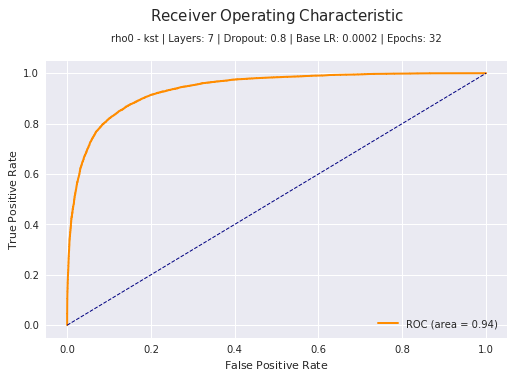

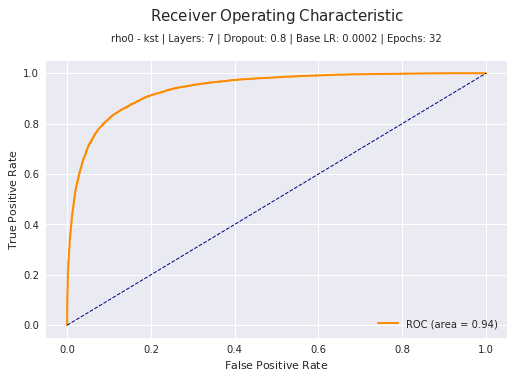

Inference complete. Duration: 7.63826 s


In [12]:
ckpt = tf.train.get_checkpoint_state(directories.checkpoints)
#vDNN = vanillaDNN(config, training = False)
network_output = vDNN.predict(ckpt)

np.save(os.path.join(directories.checkpoints, '{}_{}_y_pred.npy'.format(config.channel, config.mode)), network_output)
np.save(os.path.join(directories.checkpoints, '{}_{}_y_test.npy'.format(config.channel, config.mode)), df_y_test.values)